<a href="https://colab.research.google.com/github/2303A51036/Explainable-ai-lab/blob/main/XAI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import PartialDependenceDisplay

In [8]:
from scipy.stats import wasserstein_distance, spearmanr

In [9]:
df = pd.read_csv("/content/diabetes.csv")
print("✅ Dataset loaded! Shape:", df.shape)
print(df.head())


✅ Dataset loaded! Shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [57]:
# Assume target column is 'Outcome' (change if different)
target = "Outcome"
X = df.drop(columns=[target])
y = df[target]


In [59]:
# ===============================
# 📌 Step 3: Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [60]:
# ===============================
# 📌 Step 4: Preprocessing Pipeline
# ===============================
num_features = X.select_dtypes(include=["float64","int64"]).columns
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [13]:
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features)
])


In [61]:
# ===============================
# 📌 Step 5: Base Model (Random Forest)
# ===============================
model = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

In [15]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
print("✅ Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Model Accuracy: 0.7467532467532467

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



In [62]:
# ===============================
# 📌 Step 6: SHAP (Global + Local)
# ===============================
print("\n🔎 SHAP Analysis...")
rf = model.named_steps["clf"]
X_train_processed = preprocessor.fit_transform(X_train)


🔎 SHAP Analysis...


In [22]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_processed)

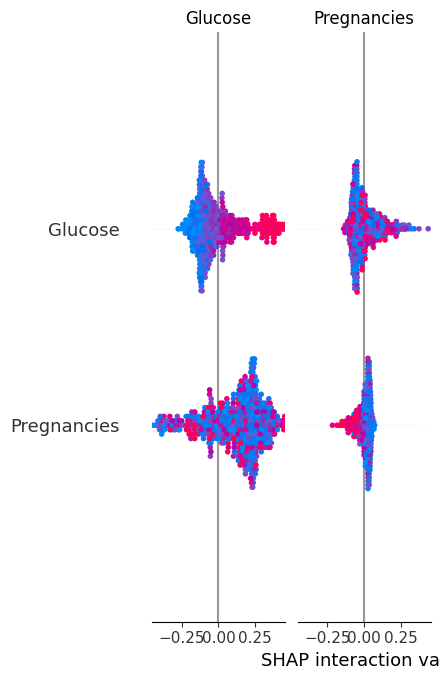

In [23]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [27]:
explainer = shap.TreeExplainer(rf)

In [28]:
shap_values = explainer.shap_values(X_train_processed)

In [63]:
# ===============================
# 📌 Step 7: LIME
# ===============================
print("\n🔎 LIME Analysis...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=["No Diabetes", "Diabetes"],
    mode="classification"
)


🔎 LIME Analysis...


In [41]:
def pipeline_predict(data):
    return model.predict_proba(pd.DataFrame(data, columns=X.columns))


In [42]:
i = 5  # pick one test sample
exp = lime_explainer.explain_instance(
    X_test.iloc[i].values,
    pipeline_predict,   # use wrapped function instead of model.predict_proba
    num_features=5
)
exp.show_in_notebook(show_table=True)

In [64]:
# ===============================
# 📌 Step 8: PDP + ICE
# ===============================
print("\n🔎 PDP + ICE Analysis...")
features_to_plot = ["Glucose", "BMI"]


🔎 PDP + ICE Analysis...


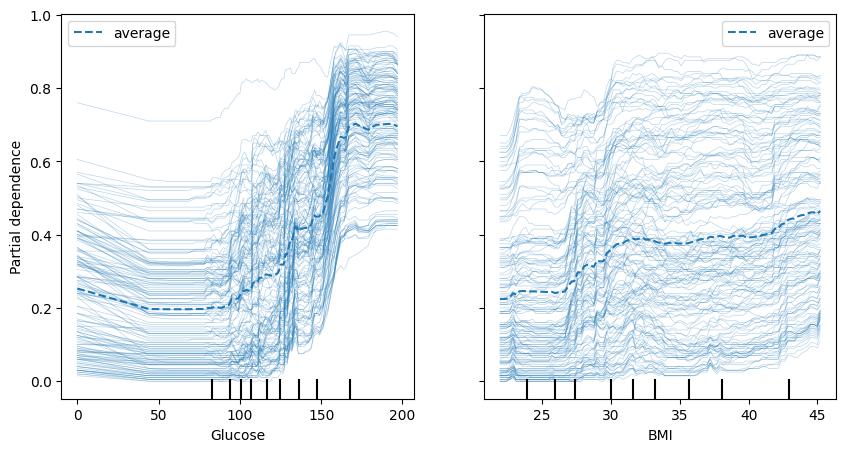

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
PartialDependenceDisplay.from_estimator(
    model, X_test, features_to_plot, kind="both", ax=ax
)
plt.show()

In [65]:
# ===============================
# 📌 Step 9: White-box Model (Logistic Regression)
# ===============================
print("\n🔎 White-box Logistic Regression...")
whitebox_model = Pipeline([
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter=1000))
])
whitebox_model.fit(X_train, y_train)



🔎 White-box Logistic Regression...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('logreg', LogisticRegression(max_iter=1000))])

In [46]:
coef = whitebox_model.named_steps["logreg"].coef_[0]
importance = pd.DataFrame({"Feature": num_features, "Coefficient": coef})
print(importance.sort_values(by="Coefficient", ascending=False))


                    Feature  Coefficient
1                   Glucose     1.144151
5                       BMI     0.713893
0               Pregnancies     0.373178
6  DiabetesPedigreeFunction     0.255527
7                       Age     0.184179
3             SkinThickness     0.066535
4                   Insulin    -0.127308
2             BloodPressure    -0.197637


In [66]:
# ===============================
# 📌 Step 10: Xi Technique (Feature Ranking)
# ===============================
print("\n🔎 Xi Technique...")
xi_scores = {}
for col in num_features:
    vals0 = X[y==0][col].dropna()
    vals1 = X[y==1][col].dropna()
    if len(vals0)>0 and len(vals1)>0:
        xi_scores[col] = wasserstein_distance(vals0, vals1)
    else:
        xi_scores[col] = 0

xi_df = pd.DataFrame.from_dict(xi_scores, orient="index", columns=["Xi_Score"])
print(xi_df.sort_values("Xi_Score", ascending=False))


🔎 Xi Technique...
                           Xi_Score
Insulin                   34.784418
Glucose                   31.406179
Age                        6.184567
BMI                        4.838337
BloodPressure              4.746776
SkinThickness              3.673015
Pregnancies                1.567672
DiabetesPedigreeFunction   0.121130


In [48]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd
from sklearn.model_selection import train_test_split


In [49]:
# =========================
# 1. Load Data
# =========================
df = pd.read_csv("/content/diabetes.csv")

In [50]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================

In [52]:
# 2. Preprocessing + Model
# =========================
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [53]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:02:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [54]:
xgb_model = pipeline.named_steps['model']